## Requirements

In [1]:
import copy
import functools
import itertools
import matplotlib
import matplotlib.pyplot

## Problem setting

Decimal numbers are represented as binary numbers on computers.  Given an $N$-bit representation, each positive integer $n \lt 2^N - 1$ can be written as a sum of powers of 2, i.e.,
$$
  n = \sum_{i=0}^{N-1} b_i 2^i
$$
where $b_i \in \{0, 1\}$ is the bit at position $i$.  Note that $b_0$ is the least, and $b_{N-1}$ the most siginficant bit.  The number in binary notation is:
$$
  b_{N-2}\,b_{N-2}\dots b_1\,b_0
$$
For example, the decimal number 5 would be represented in 4-bit representation as $0101_2$.

If you also want to present negative numbers, the most significant bit $b_{N-1}$ will denote the sign of the number, i.e., for positive integers, $b_{N-1} = 0$, while for negative numbers $b_{N-1} = 1$.  This implies that an $N$-bit representation can represent an integer $n$ only if $-2^{N-1} \le n < 2^{N -1}$.

The encoding used on modern hardware uses 2-complement representation.  For $0 \le n < 2^{N-1}$, the econding is done as explained above, e.g., for $N = 4$, $7$ would be represted as $0111_2$.
For $n = -2^{N-1}$ all bits are zero, except the  most significant one, e.g., for $N = 4$, $-8$ would be represented as $1000_2$.
For $-2^{N - 1} < n < 0$, the following algorithm is used:
* Encode $|n|$ in binary representation as before.
* Take the 1-complement of the resulting encoding, i.e., $1 \mapsto 0$ and $0 \mapsto 1$.
* Add 1 to the binary number, taking into account overflow.

For example, for $N = 4$, consider $n = -6$.  The binary representation of $|-6|$ is $0110_2$.  The 1-complement is $1001_2$, and adding 1, i.e., $0001_2$ to that yields $1010_2$.

## Implementation

You can use a list to represent a binary number, e.g., `[0, 1, 1, 1]` would represent 7.  The first element of this list is the most significant bit, the last the least significant bit.  In 2-complement representation, the most significant bit represents the sign.

It is convenient to have a function to convert a list of bits to a string.

In [2]:
def binary2str(bits: list[int]) -> str:
    '''Convert a binary representation to a string.
    
    Parameters
    ----------
    bits: list[int]
        bit representation of an integer in 2-complement representation, most significant bit first.

    Returns
    -------
    str
        string representation of the binary number
    '''
    return ''.join(str(bit) for bit in bits)

### Increment function

You need a function to increment a number in 2-complement representation by 1.  Care has to be taken that the carry is handled correctly.

For $N = 3$, -4 is represented as $100_2$, so adding 1 to it should result in -3, or $101_2$.  The increment operator should yield the following sequence when applied to -4 for $N = 3$:
$$
  \begin{array}{rcl}
      100_2 \; (-4) & \mapsto & 101_2 \; (-3) \\
                 & \mapsto & 110_2 \; (-2) \\
                 & \mapsto & 111_2 \; (-1) \\
                 & \mapsto & 000_2 \; (0) \\
                 & \mapsto & 001_2 \; (1) \\
                 & \mapsto & 010_2 \; (2) \\
                 & \mapsto & 011_2 \; (3) \\
                 & \mapsto & 100_2 \; (-4) \\
                 & \mapsto & \ldots
  \end{array}
$$

In [3]:
def incr(bits: list[int]) -> None:
    '''Increment a binary number in 2-complement representation by 1.
    
    Parameters
    ----------
    bits: list[int]
        bit representation of an integer in 2-complement representation, most significant bit first.
    '''
    carry = 1
    pos = -1
    while carry == 1 and pos > -len(bits):
        if bits[pos] == 1:
            bits[pos] = 0
        else:
            bits[pos] = 1
            carry = 0
        pos -= 1
    if carry:
        bits[0] = 0 if bits[0] else 1

To check the result for $N = 3$, you can start at -8, and apply the increment function.

In [4]:
N = 3
bits = [1] + [0]*(N - 1)
for n in range(-2**(N - 1), 2**N):
    print(f'{n:2d} -> {binary2str(bits)}')
    incr(bits)

-4 -> 100
-3 -> 101
-2 -> 110
-1 -> 111
 0 -> 000
 1 -> 001
 2 -> 010
 3 -> 011
 4 -> 100
 5 -> 101
 6 -> 110
 7 -> 111


The implementation works correctly for -1, resulting in 0.  It also correctly overflows for 3, resulting in -4.

### One-complement

The 1-complement operation simply flips all the bits, i.e., bits that are 0 are set to 1, and vice versa.

In [5]:
def one_complement(bits: list[int]) -> None:
    '''Replace the bit representation by its 1-complement.
    
    Parameters
    ----------
    bits: list[int]
        bit representation
    '''
    for i, bit in enumerate(bits):
        bits[i] = 0 if bit else 1

### Decimal to binary conversion

With the functions you have defined so far, it is now easy to implement the decimal to binary conversion for a given $N$.  The function should check that the integer $n$ to convert is in the correct range, i.e., $-2^{N-1} \le n < 2^{N-1}$, if not, it raises a `ValueError` expection.

In [6]:
def decimal2binary(n: int, nr_bits=8) -> list[int]:
    '''Convert a decimal number to 2-complement binary representation.
    
    Parameters
    ----------
    n: int
        decimal number to convert
    nr_bits: int
        number of bits in the representation (default is 8)
    
    Returns
    -------
    list[int]
        bit representation of the number, most significant (sign) bit first, least significant bit last

    Raises
    ------
    ValueError
        if n is not in range
    '''
    if -2**(nr_bits - 1) <= n < 2**(nr_bits - 1):
        bits = []
        must_complement = n < 0 and n != -2**(nr_bits - 1)
        n = abs(n)
        while n:
            bits.insert(0, n & 1)
            n >>= 1
        bits = [0]*(nr_bits - len(bits)) + bits
        if must_complement:
            one_complement(bits)
            incr(bits)
        return bits
    else:
        raise ValueError(f'integer {n} can not be encoding using {nr_bits} bits')

This can be tested for $N = 3$.

In [7]:
N = 3
for n in range(-2**(N - 1), 2**(N - 1)):
    bits = decimal2binary(n, nr_bits=N)
    print(f'{n:2d} -> {binary2str(bits)}')

-4 -> 100
-3 -> 101
-2 -> 110
-1 -> 111
 0 -> 000
 1 -> 001
 2 -> 010
 3 -> 011


You should also check that for values of $n$ that are not in range, the expected exception is raised.

In [8]:
try:
    N = 3
    _ = decimal2binary(2**(N - 1), nr_bits=N)
    assert false
except ValueError as e:
    print(f'As expected: {e}')

As expected: integer 4 can not be encoding using 3 bits


In [9]:
try:
    N = 3
    _ = decimal2binary(-2**(N - 1) - 1, nr_bits=N)
    assert false
except ValueError as e:
    print(f'As expected: {e}')

As expected: integer -5 can not be encoding using 3 bits


### Binary to decimal conversion

You can now also easily write the inverse function, i.e., a function that converts a binary number in 2-complement representation to decimal representation.

In [10]:
def binary2decimal(bits: list[int]) -> int:
    '''Convert a binary number in 2-complement representation to decimal.
    
    Parameters
    ----------
    bits: list[int]
        bit representation of an integer in 2-complement representation, most significant bit first
    
    Returns
    -------
    int
        decimal representation of the number
    '''
    # as bits is nnutable, and this algorithm is destructive, create a work copy of the argument first
    bits = copy.copy(bits)
    is_negative = bits[0] == 1
    nr_bits = len(bits)
    # the most significant bit only determines the sign,so pop it
    _ = bits.pop(0)
    if is_negative:
        one_complement(bits)
    n = 0
    multiplier = 2**(nr_bits - 2)
    for bit in bits:
        if bit:
            n += multiplier
        multiplier >>= 1
    return -(n + 1) if is_negative else n

Now you can verify everything works correctly by roundtripping, again for $N = 3$.

In [11]:
N = 3
for n in range(-2**(N - 1), 2**(N - 1)):
    bits = [bit for bit in decimal2binary(n, nr_bits=N)]
    new_n = binary2decimal(bits)
    print(f'{n:2d} -> {binary2str(bits)} -> {new_n:2d}')
    assert n == new_n

-4 -> 100 -> -4
-3 -> 101 -> -3
-2 -> 110 -> -2
-1 -> 111 -> -1
 0 -> 000 ->  0
 1 -> 001 ->  1
 2 -> 010 ->  2
 3 -> 011 ->  3


Indeed, `decimal2binary(binary2decimal(n)) == n` for all values in range.

In [12]:
N = 3
bits = [1] + [0]*(N - 1)
for n in range(2**N):
    n = binary2decimal(bits)
    new_bits = decimal2binary(n, nr_bits=N)
    print(f'{binary2str(bits)} -> {n:2d} -> {binary2str(new_bits)}')
    assert bits == new_bits
    incr(bits)

100 -> -4 -> 100
101 -> -3 -> 101
110 -> -2 -> 110
111 -> -1 -> 111
000 ->  0 -> 000
001 ->  1 -> 001
010 ->  2 -> 010
011 ->  3 -> 011


The roundtrip also works in the other direction.

### Addition

A major advantage of the 2-complement representation is that addition can use the same logic, regardless of the the sign of the operands.

In [13]:
def add(bits1: list[int], bits2: list[int]) -> list[int]:
    '''Add two numbers in 2-complement representation
    
    Parameters
    ----------
    bits1: list[int]
        bit representation of the first integer in 2-complement representation, most significant bit first.
    bits2: list[int]
        bit representation of the second integer in 2-complement representation, most significant bit first.

    Results
    -------
    list[int]
        bit representation of the result in 2-complement representation, most significant bit first.

    Raisss
    ------
    ValueError
        if the bit representations don't have the same number of bits
    '''
    if len(bits1) != len(bits2):
        raise ValueError(f'number of bits should be equal, but {len(bits1)} versus {len(bits2)}')
    carry = 0
    bits = []
    for bit1, bit2 in zip(bits1[::-1], bits2[::-1]):
        carry, bit = divmod(bit1 + bit2 + carry, 2)
        bits.insert(0, bit)
    return bits

In [14]:
N = 3
for n1, n2 in itertools.product(range(-2**(N - 1), 2**(N - 1)), repeat=2):
    bits1, bits2 = decimal2binary(n1, nr_bits=N), decimal2binary(n2, nr_bits=N)
    bits = add(bits1, bits2)
    n = binary2decimal(bits)
    print(f'{n1:2d} ({binary2str(bits1)}) + {n2:2d} ({binary2str(bits2)}) = {n:2d} ({binary2str(bits)})')
    s = (n1 + n2) % 2**N
    s = s if s < 2**(N - 1) else s - 2**N
    assert s == n

-4 (100) + -4 (100) =  0 (000)
-4 (100) + -3 (101) =  1 (001)
-4 (100) + -2 (110) =  2 (010)
-4 (100) + -1 (111) =  3 (011)
-4 (100) +  0 (000) = -4 (100)
-4 (100) +  1 (001) = -3 (101)
-4 (100) +  2 (010) = -2 (110)
-4 (100) +  3 (011) = -1 (111)
-3 (101) + -4 (100) =  1 (001)
-3 (101) + -3 (101) =  2 (010)
-3 (101) + -2 (110) =  3 (011)
-3 (101) + -1 (111) = -4 (100)
-3 (101) +  0 (000) = -3 (101)
-3 (101) +  1 (001) = -2 (110)
-3 (101) +  2 (010) = -1 (111)
-3 (101) +  3 (011) =  0 (000)
-2 (110) + -4 (100) =  2 (010)
-2 (110) + -3 (101) =  3 (011)
-2 (110) + -2 (110) = -4 (100)
-2 (110) + -1 (111) = -3 (101)
-2 (110) +  0 (000) = -2 (110)
-2 (110) +  1 (001) = -1 (111)
-2 (110) +  2 (010) =  0 (000)
-2 (110) +  3 (011) =  1 (001)
-1 (111) + -4 (100) =  3 (011)
-1 (111) + -3 (101) = -4 (100)
-1 (111) + -2 (110) = -3 (101)
-1 (111) + -1 (111) = -2 (110)
-1 (111) +  0 (000) = -1 (111)
-1 (111) +  1 (001) =  0 (000)
-1 (111) +  2 (010) =  1 (001)
-1 (111) +  3 (011) =  2 (010)
 0 (000)

The results can be visualized in a heatmap.

In [15]:
def visualize_addition(nr_bits: int) -> None:
    '''Visualize the addition in a heatmap.
    
    Parameters
    ----------
    nr_bits: int
        number of bits of the 2-complement representation of the operands and result
    '''
    # define a partial function for the givenvalue of nr_bits to avoid a lambda function in map
    to_bits = functools.partial(decimal2binary, nr_bits=nr_bits)

    # compute all the sums for operands in the range -2**(N - 1) to 2**(N - 1) - 1
    operands = list(range(-2**(nr_bits - 1), 2**(nr_bits - 1)))
    sums = []
    for bits1 in map(to_bits, operands):
        sums.append([])
        for bits2 in map(to_bits, operands):
            bits = add(bits1, bits2)
            n = binary2decimal(bits)
            sums[-1].append(n)

    # set the stage
    figure, axis = matplotlib.pyplot.subplots()

    # get a discrete colom map based o coolwarm
    cmap = matplotlib.pyplot.get_cmap('coolwarm', 2**nr_bits)

    # compute the norm for the heatmap values and create the heatmap
    norm = matplotlib.colors.BoundaryNorm([-(2**(nr_bits - 1) + 0.5) + i for i in range(2**nr_bits + 1)], cmap.N)
    heatmap = axis.matshow(sums, cmap=cmap, norm=norm)

    # set axis labels
    _ = axis.set_xticks(range(2**nr_bits), labels=operands)
    _ = axis.set_yticks(range(2**nr_bits), labels=operands)

    # create the color bar
    cbar = matplotlib.pyplot.colorbar(heatmap, ax=axis, ticks=range(-2**(nr_bits-1), 2**(nr_bits - 1)))
    cbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%3d'))

    # show the values in the heatmap patches
    for i in range(2**nr_bits):
        for j in range(2**nr_bits):
            red, green, blue, _ = cmap(norm(sums[i][j]))
            luminance = 0.299*red + 0.587*green + 0.114*blue
            txt_color = "black" if luminance > 0.5 else "white"
            axis.text(i, j, f'{sums[i][j]:2d}', ha='center', va='center', color=txt_color)

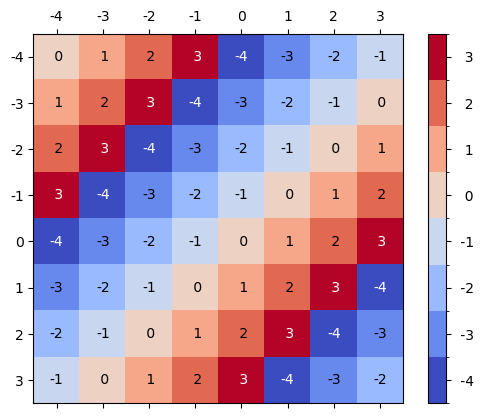

In [16]:
visualize_addition(nr_bits=3)

This representation shows the symmetry much better.

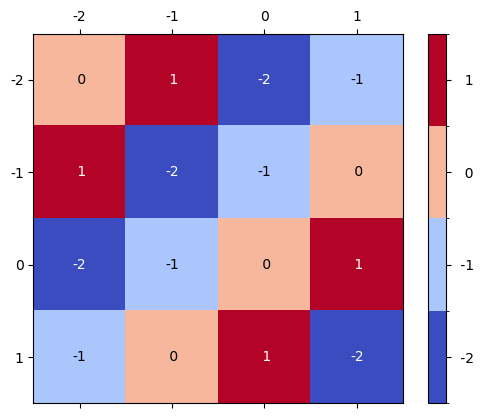

In [17]:
visualize_addition(nr_bits=2)

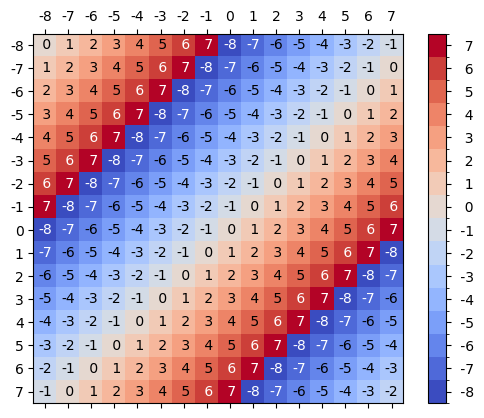

In [18]:
visualize_addition(nr_bits=4)

The pattern is similar for various bit representations.